In [1]:
import torch
import numpy as np 
import cv2 
import torchvision as tv
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import gc
import torchvision.transforms.functional as tvf
cuda = torch.device('cuda')
torch.cuda.empty_cache()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
gc.collect()

0

In [2]:
#prepare colon
xs = []
ys = []
for file in os.listdir('colon/PNG/Original/'):
    xs.append(os.path.join('colon/PNG/Original/', file))
    ys.append(os.path.join('colon/PNG/Ground Truth/', file))
csv = pd.DataFrame({\
    "in_path": xs,
    "out_path": ys,
})
csv.to_csv('train.csv', index=False)


(288, 384, 3) (288, 384) (288, 384)


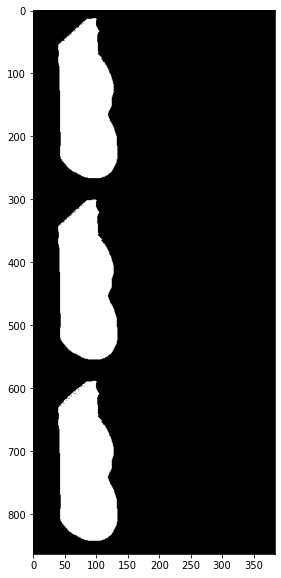

In [3]:
y = cv2.imread(ys[1])
gs = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
bin = np.where(gs > 0, 255, 0).astype(np.uint8)
print(y.shape, gs.shape, bin.shape)
gs = cv2.cvtColor(gs, cv2.COLOR_GRAY2BGR)
bin = cv2.cvtColor(bin, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(np.vstack([y, gs, bin]))

In [126]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, xs=None, ys=None, csv=None, res = (288, 288), transforms=None, seed=42) -> None:
        super().__init__()
        np.random.seed(seed)
        torch.random.manual_seed(seed)
        self.imgs = []
        self.xs = []
        self.ys = []
        if xs == None and ys == None and csv == None:
            raise Exception('all xs and ys and csv is none')
        if csv != None:
            xs = csv.in_path.to_list()
            ys = csv.out_path.to_list()
        i = 0
        for x_f, y_f in zip(sorted(xs), sorted(ys)):
            x = cv2.imread(x_f)
            y = cv2.imread(y_f)
            y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
            y = np.where(y > 0, 255, 0).astype(np.uint8)
            x = cv2.resize(x, res)
            y = cv2.resize(y, res).astype(np.bool_)
            self.xs.append(x)
            self.ys.append(y)
            i += 1
            if i  > 10:
                break
        self.ids = np.arange(len(self.xs))
        self.transforms = transforms
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        if idx == 0:
            self.ids = np.random.permutation(self.ids)
        x, y = self.xs[self.ids[idx]], self.ys[self.ids[idx]]
        print(x.shape, y.shape)
        x = x / 255.
        x = {'x':x, "y": y.reshape(y.shape[0], y.shape[1], 1)}
        if self.transforms != None:
            x = self.transforms(x)
        # smp = {"x": x, "y": y}
        # print(type(x))
        return x
def transforms_fn(smp: dict):
    smp = ToTensor2(smp)
    x, y = smp['x'], smp['y']
    dst = torch.distributions.uniform.Uniform(0.0, 1.0)
    dst_2 = torch.distributions.uniform.Uniform(0.5, 2.5)
    shp = [1]
    rnd = dst.sample(shp)[0]
    if rnd > 0.5: #
        scale = dst_2.sample(shp)[0]
        x = tvf.adjust_brightness(x, brightness_factor=scale)
        
    rnd = dst.sample(shp)[0]
    if rnd > 0.5:
        brightness_scale = dst_2.sample(shp)[0]
        x = tvf.adjust_sharpness()
        
    
class ToTensor2(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, s):
        # return s
        print(type(s))
        print(s['x'].shape, s['y'].shape)
        
        lli, hli = s['x'].copy(),s['y'].copy()
        # print('coming_shape: ', lli.shape, hli.shape)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        # lli = lli.transpose((0, 3, 1, 2))
        # hli = hli.transpose((0, 3, 1, 2))
        lli = lli.transpose(( 2, 0, 1))
        hli = hli.transpose(( 2, 0, 1))
        return {'x': torch.from_numpy(lli),
                'y': torch.from_numpy(hli)}

class RandomRotate(object): 
    def __call__(self, s):
        x, y = s['x'], s['y']
        
        return {'x': x, 'y': y}


        
transforms = tv.transforms.Compose([\
    tv.transforms.RandomHorizontalFlip(.5),
    tv.transforms.RandomVerticalFlip(.5),
    tv.transforms.RandomAdjustSharpness(.2),
    ToTensor2(),
    # tv.transforms.ToTensor(),
    # tv.transforms.ConvertImageDtype(torch.float32)
])


batch_size = 2
workers = 0

ds = Dataset(xs, ys, transforms=transforms)


In [128]:
s = ds.__getitem__(1)
s['x'].shape

(288, 288, 3) (288, 288)


TypeError: img should be PIL Image. Got <class 'dict'>

In [114]:
torch.transpose(s['x'], 2,0).shape

torch.Size([288, 288, 3])

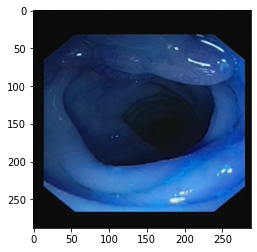

In [115]:
plt.imshow(torch.transpose(s['x'],0,2 ))

In [ ]:
# class PositionalEncoding2d(torch.nn.Module):
#     def __init__(self, channels):
#         self.channels = int(np.ceil(channels//2))
#         inv_freq = 1. / (1000 ** (torch.arange(0, channels, 2).float() / channels))
#         self.register_buffer('inv_freq', inv_freq)
        
#     def forward(self, x):
#         bs, h, w, ch = x.shape
#         hs = torch.arange(x).type(self.inv_freq.type())
#         ws = torch.arange(w).type(self.inv_freq.type())
        
#         sin_h = torch.einsum("i,j->ij", hs, self.inv_freq)
#         sin_w = torch.einsum("i,j->ij", ws, self.inv_freq)
#         return
    
    
    
# def getPositionalEmbeddings(seq, dims):
#     # out = torch.ones(seq, dims)
#     out = np.zeros((seq,dims)).tolist()
#     out = [np.sin(i / (10000 ** (j / dims))) if j % 2 == 0 else np.cos(i / (10000 ** ((j-1) / dims))) \
#         for i in range(len(out)) for j in range(len(out[0]))]
#     out = torch.Tensor(out).reshape(seq, dims).type(torch.float32)
#     return out 


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import math
from positional_encodings.torch_encodings import PositionalEncodingPermute2D


class MHSA_Dense(torch.nn.Module):
    def __init__(self, embed_dim, bias=False, heads=1) -> None:
        super(MHSA_Dense, self).__init__()
        self.inp_dims = embed_dim
        self.heads = heads
        self.d_head = int(self.inp_dims / self.heads) 
        # self.linear = torch.nn.Linear(self., self.d_head, bias=bias)
        self.linear = torch.nn.Linear(self.inp_dims, self.inp_dims, bias=bias)
    def forward(self, x):
        x = self.linear(x)
        return x
            

class MHSA(torch.nn.Module):
    def  __init__(self, chans=512, heads=1) -> None:
        super(MHSA, self).__init__()
        self.chans = chans
        self.heads = heads
        self.d_head = int(self.chans / self.heads) 
        self.q = MHSA_Dense(self.chans, bias=False, heads=self.heads)
        self.k = MHSA_Dense(self.chans, bias=False, heads=self.heads)
        self.v = MHSA_Dense(self.chans, bias=False, heads=self.heads)
        self.activation = torch.nn.Softmax(dim=1)
        self.positional_embedder = PositionalEncodingPermute2D(self.chans)
        
    def forward(self, x):
        dims = x.size()
        positional_embeddings = self.positional_embedder(x)
        x = x + positional_embeddings
        x = x.reshape(dims[0], dims[1], dims[2]*dims[3]).permute(0, 2, 1)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        print(x.shape, q.shape, k.shape, v.shape)
        m = torch.matmul(q, k.permute(0,2,1)) / (dims[1] ** .5) # channels
        m = self.activation(m)
        
        x = torch.matmul(m, v)
        x = x.permute(0,2,1)
        
        return x.reshape(dims[0], dims[1], dims[2], dims[3])
class MHCA(torch.nn.Module):
    def __init__(self, chans=256, chan_mul = 2, heads = 8) -> None:
        super(MHCA, self ).__init__()
        self.chans = chans
        self.chan_mul = chan_mul # y's chanel is half of ys
        self.positional_embdedder_s = PositionalEncodingPermute2D(self.chans)
        self.positional_embdedder_y = PositionalEncodingPermute2D(self.chans * chan_mul)
        self.heads = heads
        self.conv_s = Conv1KBnRelu(chans, pool=True)
        self.conv_y = Conv1KBnRelu(chans*2)
        self.q = MHSA_Dense(self.chans * chan_mul, bias=False, heads=self.heads)
        self.k = MHSA_Dense(self.chans * chan_mul, bias=False, heads=self.heads)
        self.v = MHSA_Dense(self.chans, bias=False, heads=self.heads)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
        self.conv_1 = torch.nn.Conv2d(self.chans, self.chans, 1)
        self.batch_normalizer = torch.nn.BatchNorm2d(self.chans)
        self.activation = torch.nn.Sigmoid() #paper uses sigmoid
        self.upsampler = torch.nn.ConvTranspose2d(self.chans, self.chans, 2, 2, bias=False)
        
    def forward(self, s, y):
        sshp, h, w = s.shape, y.shape[2], y.shape[3]
        
        pes = self.positional_embdedder_s(s)
        pey = self.positional_embdedder_y(y)
        s = out_s = s + pes
        y = out_y = y + pey
        s = self.conv_s(s)
        y = self.conv_y(y)
        
        s = s.reshape(s.shape[0], s.shape[1], s.shape[2] * s.shape[3]).permute(0,2,1) # should reshape to incorporate nheads
        y = y.reshape(y.shape[0], y.shape[1], y.shape[2] * y.shape[3]).permute(0,2,1)

        q = self.q(y)
        k = self.k(y)
        v = self.v(s)
        a = torch.matmul(q, k.permute(0,2,1)) / (sshp[1] ** .5) # channels
        a = self.activation(a)
        
        x = torch.matmul(a, v).permute(0,2,1).reshape(sshp[0], sshp[1], h, w)
        x = self.conv_1(x)
        x = self.batch_normalizer(x)
        x = self.activation(x)
        x = self.upsampler(x)  #z
        out_s = x * out_s
        
        return out_s, out_y
        
class Conv1KBnRelu(torch.nn.Module):
    def __init__(self, channels, bias=True, pool=False) -> None:
        super(Conv1KBnRelu, self).__init__()
        self.pool = pool
        if pool:
            self.pooler = torch.nn.MaxPool2d(2)
        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=1, bias=bias)
        self.batch_normalizer = torch.nn.BatchNorm2d(channels)
        self.activation = torch.nn.LeakyReLU(inplace=True)
    def forward(self, x):
        if self.pool:
            x = self.pooler(x)
        x = self.conv(x)
        x = self.batch_normalizer(x)
        x = self.activation(x)
        return x

class Conv3x2(torch.nn.Module):
    def __init__(self, in_chan, out_chan) -> None:
        super(Conv3x2, self).__init__()
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.conv1 = torch.nn.Conv2d(in_chan, out_chan, 3, 1, 1)
        self.bn1 = torch.nn.BatchNorm2d(out_chan)
        self.conv2 = torch.nn.Conv2d(out_chan, out_chan, 3, 1, 1)
        self.bn2 = torch.nn.BatchNorm2d(out_chan)
        self.activation = torch.nn.LeakyReLU(.02,inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        return x


class UNet_trans(torch.nn.Module):
    def __init__(self, block_size, in_channel=4, kernel_size=3, dialation=1) -> None:
        super(UNet_trans, self).__init__()
        self.block_size = block_size 
        
        self.activation = torch.nn.LeakyReLU(.02, True)
        self.max_pool = torch.nn.MaxPool2d(2, 2, 0, ceil_mode=True)
        self.upsampler = torch.nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)
        
        self.convF1 = torch.nn.Conv2d(in_channel, 32, kernel_size, 1, 1, dialation, bias=True)
        self.convF2 = torch.nn.Conv2d(32, 32, kernel_size, 1, 1, dialation, bias=True)
        
        self.convF3 = torch.nn.Conv2d(32, 64, kernel_size, 1, 1, dialation, bias=True)
        self.convF4 = torch.nn.Conv2d(64, 64, kernel_size, 1, 1, dialation, bias=True)
        
        self.convF5 = torch.nn.Conv2d(64, 128, kernel_size, 1, 1, dialation, bias=True)
        self.convF6 = torch.nn.Conv2d(128, 128, kernel_size, 1, 1, dialation, bias=True)
        
        self.convF7 = torch.nn.Conv2d(128, 256, kernel_size, 1, 1, dialation, bias=True)
        self.convF8 = torch.nn.Conv2d(256, 256, kernel_size, 1, 1, dialation, bias=True)
        
        self.convF9 = torch.nn.Conv2d(256, 512, kernel_size, 1, 1, dialation, bias=True)
        self.convF10 = torch.nn.Conv2d(512, 512, kernel_size, 1, 1, dialation, bias=True)
        
        self.mhsa = MHSA(512)
        
        self.conv_upB10 = torch.nn.ConvTranspose2d(512, 512, 2, 2, bias=False)
        self.mhca10 = MHCA(256)
        # self.convB10 = torch.nn.Conv2d(512, 512, kernel_size, 1, 1, dialation, bias=True)
        # self.convB9 = torch.nn.Conv2d(256, 256, kernel_size, 1, 1, dialation, bias=True)
        self.convB9 = torch.nn.Conv2d(512, 256, 1, 1, 0, dialation, bias=True)
        self.bn10 = torch.nn.BatchNorm2d(256)
        self.conv3x2_10 = Conv3x2(512, 256)
        
        
        self.mhca8 = MHCA(128)
        self.conv_upB8 = torch.nn.ConvTranspose2d(256, 256, 2, 2, bias=False)
        # self.convB8 = torch.nn.Conv2d(256, 128, kernel_size, 1, 1, dialation, bias=True)
        # self.convB7 = torch.nn.Conv2d(128, 128, kernel_size, 1, 1, dialation, bias=True)
        self.convB7 = torch.nn.Conv2d(256, 128, 1, 1, 0, dialation, bias=True)
        self.bn8 = torch.nn.BatchNorm2d(128)
        self.conv3x2_8 = Conv3x2(256, 128)
        
        self.mhca6 = MHCA(64)
        self.conv_upB6 = torch.nn.ConvTranspose2d(128, 128, 2, 2, bias=False)
        # self.convB6 = torch.nn.Conv2d(128, 64, kernel_size, 1, 1, dialation, bias=True)
        # self.convB5 = torch.nn.Conv2d(64, 64, kernel_size, 1, 1, dialation, bias=True)
        self.convB5 = torch.nn.Conv2d(128, 64, 1, 1, 0, dialation, bias=True)
        self.bn6 = torch.nn.BatchNorm2d(64)
        self.conv3x2_6 = Conv3x2(128, 64)
        
        self.mhca4= MHCA(32)
        self.conv_upB4 = torch.nn.ConvTranspose2d(64, 64, 2, 2, bias=False)
        # self.convB4 = torch.nn.Conv2d(64, 32, kernel_size, 1, 1, dialation, bias=True)
        # self.convB3 = torch.nn.Conv2d(32, 32, kernel_size, 1, 1, dialation, bias=True)
        self.convB3 = torch.nn.Conv2d(64, 32, 1, 1, 0, dialation, bias=True)
        self.bn4 = torch.nn.BatchNorm2d(32)
        self.conv3x2_4 = Conv3x2(64, 32)
        
        self.convB = torch.nn.Conv2d(32, 3 * self.block_size * self.block_size, 1, 1, 0, bias=True)
        
    def init_weights(self, seed=42):
        np.random.seed(seed)
        torch.manual_seed(seed)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()
            elif isinstance(m, torch.nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
    def forward(self, x):
        x = self.convF1(x)
        x = self.activation(x)
        x = self.convF2(x)
        x = self.activation(x)
        up2 = x
        
        x = self.max_pool(x)
        x = self.convF3(x)
        x = self.activation(x)
        x = self.convF4(x)
        x = self.activation(x)
        up4 = x
        
        x = self.max_pool(x)
        x = self.convF5(x)
        x = self.activation(x)
        x = self.convF6(x)
        x = self.activation(x)
        up6 = x
        
        x = self.max_pool(x)
        x = self.convF7(x)
        x = self.activation(x)
        x = self.convF8(x)
        x = self.activation(x)
        up8 = x
        
        x = self.max_pool(x)
        x = self.convF9(x)
        x = self.activation(x)
        x = self.convF10(x)
        x = self.activation(x)
        
        x = self.mhsa(x)
        
        print(x.shape, up8.shape)
        
        s, x = self.mhca10(up8, x)
        x = self.conv_upB10(x)
        # x = self.upsampler(x)
        x = self.activation(x)
        x = self.convB9(x)
        x = self.bn10(x)
        x = self.activation(x)
        x = torch.cat((x, s), dim=1)
        x = self.conv3x2_10(x)
        
        s, x = self.mhca8(up6, x)
        x = self.conv_upB8(x)
        # x = self.upsampler(x)
        x = self.activation(x)
        x = self.convB7(x)
        x = self.bn8(x)
        x = self.activation(x)
        x = torch.cat((x, s), dim=1)
        x = self.conv3x2_8(x)
        
        s, x = self.mhca6(up4, x)
        x = self.conv_upB6(x)
        # x = self.upsampler(x)
        x = self.activation(x)
        x = self.convB5(x)
        x = self.bn6(x)
        x = self.activation(x)
        x = torch.cat((x, s), dim=1)
        x = self.conv3x2_6(x)
        
        s, x = self.mhca4(up2, x)
        x = self.conv_upB4(x)
        # x = self.upsampler(x)
        x = self.activation(x)
        x = self.convB3(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = torch.cat((x, s), dim=1)
        x = self.conv3x2_4(x)
        
        # x = self.
        # x = self.conv_upB10(x)
        # x = torch.cat((x[:, :, :up8.size(2), :up8.size(3)], up8), 1)
        # x = self.convB10(x)
        # x = self.activation(x)
        # x = self.convB9(x)
        # x = self.activation(x)
        
        # x = self.conv_upB8(x)
        # x = torch.cat((x[:, :, :up6.size(2), :up6.size(3)], up6), 1)
        # x = self.convB8(x)
        # x = self.activation(x)
        # x = self.convB7(x)
        # x = self.activation(x)
        
        # x = self.conv_upB6(x)
        # x = torch.cat((x[:, :, :up4.size(2), :up4.size(3)], up4), 1)
        # x = self.convB6(x)
        # x = self.activation(x)
        # x = self.convB5(x)
        # x = self.activation(x)
        
        
        # x = self.conv_upB4(x)
        # x = torch.cat((x[:, :, :up2.size(2), :up2.size(3)], up2), 1)
        # x = self.convB4(x)
        # x = self.activation(x)
        # x = self.convB3(x)
        # x = self.activation(x)
        
        #####
        
        x = self.convB(x)
        print(x.shape)
        x = self.pixel_shuffle(x, 1, True)
        # x = torch.nn.PixelShuffle(2)(x)
        return x
        
    def pixel_shuffle(self, input, upscale_factor, depth_first=False):
        r"""Rearranges elements in a tensor of shape :math:`[*, C*r^2, H, W]` to a
        tensor of shape :math:`[C, H*r, W*r]`.
        See :class:`~torch.nn.PixelShuffle` for details.
        Args:
            input (Tensor): Input
            upscale_factor (int): factor to increase spatial resolution by
        Examples::
            >>> ps = nn.PixelShuffle(3)
            >>> input = torch.empty(1, 9, 4, 4)
            >>> output = ps(input)
            >>> print(output.size())
            torch.Size([1, 1, 12, 12])
        """
        batch_size, channels, in_height, in_width = input.size()
        channels //= upscale_factor ** 2

        out_height = in_height * upscale_factor
        out_width = in_width * upscale_factor

        if not depth_first:
            input_view = input.contiguous().view(
                batch_size, channels, upscale_factor, upscale_factor,
                in_height, in_width)
            shuffle_out = input_view.permute(0, 1, 4, 2, 5, 3).contiguous()
            return shuffle_out.view(batch_size, channels, out_height, out_width)
        else:
            input_view = input.contiguous().view(batch_size, upscale_factor, upscale_factor, channels, in_height, in_width)
            shuffle_out = input_view.permute(0, 4, 1, 5, 2, 3).contiguous().view(batch_size, out_height, out_width,
                                                                                channels)
            return shuffle_out.permute(0, 3, 1, 2)
        
torch.cuda.empty_cache()
model = UNet_trans(block_size=1, in_channel= 3).to(cuda)
model.half()
a = torch.rand(1, 3, 224*2, 224*2).type(torch.float16).to(cuda)
print(count_parameters(model))
model(a).shape

11079395
torch.Size([1, 784, 512]) torch.Size([1, 784, 512]) torch.Size([1, 784, 512]) torch.Size([1, 784, 512])
torch.Size([1, 512, 28, 28]) torch.Size([1, 256, 56, 56])


RuntimeError: CUDA out of memory. Tried to allocate 4.69 GiB (GPU 0; 8.00 GiB total capacity; 5.42 GiB already allocated; 0 bytes free; 5.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [133]:
import PIL.Image as pil
pil.open(xs[0]).getdata().shape

AttributeError: 'ImagingCore' object has no attribute 'shape'

tensor([-19.8830])